In [1]:
import networkx as nx 
from random import choice,randint
import cupy as cp
from numba import cuda
import numpy as np
import matplotlib.pyplot as plt
import sys

class TabuSearch():

    def __init__(self,nbiter,dt,nv,filename,alpha=1):
        self.nbiterations = nbiter
        self.current_iter = 0
        self.tabu_duration = dt 
        self.size_solution = nv


        # tabu modification report 2
        self.lower_bound = int(alpha*0.5*np.sqrt(nv))
        self.upper_bound = int(alpha*1.5*np.sqrt(nv))
        self.bounds = np.random.randint(self.lower_bound,self.upper_bound,size=self.nbiterations)
        #tabu frequency 
        self.frequencies = [[0 for i in range(nv)] for j in range(nv)]
        self.FTD1 = lambda x:10 + int(alpha*(self.frequencies[x]/self.size_solution))

        #tabu frequency 2 
        self.frequencies2 = [[0 for i in range(nv)] for j in range(nv)]
        self.FTD2 = lambda x:10 + int(alpha*(self.frequencies2[x]/self.size_solution))


        self.distance_matrix = self.read_file_and_build_distance(nv,filename)
        self.current = solution(nv)
        tmp = self.current.evaluate(self.distance_matrix)
        self.current.fitness = tmp

        print("the initial random solution is")
        self.current.show()

        self.tabu_list = [[-1 for j in range(nv)] for i in range(nv)]
        self.tabu_list2 = [[-1 for j in range(self.size_solution)] for i in range(self.tabu_duration)]
        self.count_nn = 0

#         self.current.plot_graph(self.distance_matrix)

    def read_file_and_build_distance(self,nv,filename):
        with open(filename , mode ="r") as file:
            input_data = [d.strip().split() for d in file.readlines()]
            if len(input_data[0]) != len(input_data[-1]):
                distances = [[None for j in range(nv)] for i in range(nv)]
                for i in range(nv):
                    row = 0
                    for j in range(i+1,nv):
                        distances[i][j] = int(input_data[i][row])
                        distances[j][i] = distances[i][j]
                        row += 1 
                for i in range(nv):
                    distances[i][i] = - 10 
            elif len(input_data[0]) == len(input_data[-1]):
                print(2)
                distances = [[None for j in range(nv)] for i in range(nv)]
                for i in range(nv):
                    for j in range(nv):
                        distances[i][j] = int(input_data[i][j])
        return distances

    def not_tabu2(self,solution):
        for i in range(self.tabu_duration):
            for j in range(1,self.size_solution):
                if self.tabu_list2[i][j] != solution.cities[j]:
                    break
                elif j == self.size_solution - 1 :
                    return False
        
        for i in range(self.tabu_duration):
            for j in range(1,self.size_solution):
                if self.tabu_list2[i][j] != solution.cities[self.size_solution - j ]:
                    break
                elif j == self.size_solution - 1 :
                    return False
        return True 
             

    def not_tabu(self,i,j):
        return self.tabu_list[i][j] < self.current_iter

    def update_tabu_list_2(self,solution , position):
        if self.tabu_duration != 0:
            for i in range(self.size_solution):
                self.tabu_list2[position][j] = solution.cities[j]
                position+=1
                if position == self.tabu_duration :
                    position = 0 

    def neighbors_2opt(self,best_i,best_j):
        best_vois = 100000
        visit = 0 
        for i in range(self.size_solution):
            for j in range(i+1,self.size_solution):
                if (((i != 0) or (j != self.size_solution -1 )) and ((i!=0) or (j!=self.size_solution -2))) :
                    self.count_nn +=1
                    visit += 1
                    self.current.inversion_list_cities(i,j)
                    tmp = self.current.evaluate(self.distance_matrix)
                    self.current.fitness = tmp 
                    if(self.not_tabu(i,j) and (self.current.fitness < best_vois)):
                        
                        best_vois = self.current.fitness
                        best_i  = i 
                        best_j = j

                    self.current.inversion_list_cities(i,j)
                    tmp = self.current.evaluate(self.distance_matrix)
                    self.current.fitness = tmp
        print("visit" , visit)
        return best_i,best_j

    def optimize(self):
        first = True 
        descent = False
        improve_sol = -1 
        n = self.size_solution
        best_solution = solution(n)
        best_iter = 0
        best_i = 0 
        best_j = 0 
        best_eval = self.current.fitness
        f_before = 10000000
        local_min = 0 
        for current_iter in range(self.nbiterations):
            best_i,best_j = self.neighbors_2opt(best_i,best_j)
            self.current.inversion_list_cities(best_i,best_j)
            self.current.order()
            tmp = self.current.evaluate(self.distance_matrix)
            self.current.fitness = tmp
            f_after = self.current.fitness

            if self.current.fitness < best_eval :
                best_eval = self.current.fitness
                best_solution.cities = self.current.cities
                best_solution.evaluate(self.distance_matrix)
                improve_sol = current_iter
                best_iter = current_iter
            else:
                if ((f_before<f_after) and (descent==True)) or ((f_before == f_after)and(first)) :
                    print("minimum local at iteration",current_iter,"min = ",f_before)
                    print("best search from previous search ",best_eval,"km")
                    first = False
                    local_min+=1
                
                if(f_before <= f_after):
                    descent = False
                else:
                    descent = True
                if (f_before != f_after) and (not first ):
                    first = True

            self.tabu_list[best_i][best_j] = current_iter + self.tabu_duration

            f_before = f_after
            print(current_iter,self.current.fitness,best_eval)
            self.current_iter = current_iter

        # best_solution.evaluate(self.distance_matrix)
        print('best iteration',best_iter)
        print('total local minima',local_min)
        return best_solution


class solution():
    
    def __init__(self,nv):
        self.restart = True 
        self.size = nv
        self.cities = [None for i in range(nv)]
        self.cities[0] = 0 
        self.fitness = 1000000
        for i in range(1,self.size):
            self.restart = True 
            while(self.restart):
                self.restart = False
                a = randint(0,self.size-1)
                for j in range(0,i):
                    if a == int(self.cities[j]) :
                        self.restart = True
            self.cities[i] = a
        
        self.order()

    def evaluate(self,distance):
        tmp = 0 
        for i in range(self.size - 1):
            tmp += distance[self.cities[i]][self.cities[i+1]]
        tmp += distance[self.cities[0]][self.cities[self.size - 1]]
        self.fitness = tmp 
        return tmp

    def order(self):
        if self.cities[0] != 0:
            position_0 = 0 
            city_c = [None for _ in range(self.size)]
            for i in range(self.size):
                city_c[i] = self.cities[i]
                if self.cities[i] == 0:
                    position_0 = i
            k = 0 
            for i in range(position_0,self.size):
                self.cities[k] = city_c[i]
                k+=1
            
            for i in range(0,position_0):
                self.cities[k] = city_c[i]
                k+=1
        
        if self.cities[1] > self.cities[self.size-1]:
            for k in range(1,2+int((self.size-2)/2)):
                inter = self.cities[k]
                self.cities[k] = self.cities[self.size - k]
                self.cities[self.size - k] = inter 
    
    def move_1_city(self,city_1,city_2):
        inter = self.cities[city_1]
        if city_1 < city_2:
            for k in range(city_1,city_2):
                self.cities[k] = self.cities[k+1]
        else:
            for k in range(city_2,city_1):
                self.cities[k] = self.cities[k+1]
        self.cities[city_2] = inter 
    
    def inversion_list_cities(self,city_1,city_2):
        for k in range(city_1,city_1 +1+ int((city_2 - city_1)/2)):
            tmp = self.cities[k] 
            self.cities[k] = self.cities[city_2 + city_1 -k]
            self.cities[city_2 + city_1 -k] = tmp
    
    def identity(self,solution):
        for i in range(1,self.size):
            if int(solution.cities[i]) != int(self.cities[i]):
                return False
        return True 
    

    def show(self):
        string = "-".join(map(str,self.cities))
        print(string)
        print("-->",self.fitness,"km")


    def plot_graph(self,distance_matrix):
        for i in range(len(distance_matrix)):
            distance_matrix[i][i] = 0
        A = np.array(distance_matrix)
        G = nx.from_numpy_matrix(A)

        edges = []
        for i in range(len(self.cities)):
            edges.append((self.cities[i-1],self.cities[i]))
        edges.append((self.cities[-1],self.cities[0]))
        labels = nx.get_edge_attributes(G,'weight')
        # G = nx.drawing.nx_agraph.to_agraph(G)  spectral_layout(G)  nx.spring_layout(G,iterations= 10000,scale=1000.0)
        #  nx.kamada_kawai_layout(G)
        nx.draw(G,  with_labels = True,pos=nx.kamada_kawai_layout(G,scale = 10)  ,node_size=200, node_color='green', prog='neato',edgelist=edges)
        # # nx.draw_networkx_nodes(G,with_labels = True,pos=nx.spring_layout(G),prog='neato',node_size=300, node_color='green')
        # nx.draw_networkx_edges(G,pos=nx.spring_layout(G),edgelist=edges,edge_color="red",prog='neato')
        plt.show()
        

def run_10_times(nb_iteration = 10,duree_tabou  = 0,nb_villes = 10,filename = "distances_entre_villes_10.txt",iteration = 1):
    for _ in range(iteration):
        tabu = TabuSearch(nb_iteration,duree_tabou,nb_villes,filename)
        best_sol = tabu.optimize()
        best_sol.show()
        print(tabu.count_nn,"number of solution visited")
        print()
        best_sol.plot_graph(tabu.distance_matrix)

filename = "distances_entre_villes_50.txt"

In [2]:
run_10_times(nb_iteration = 10000,duree_tabou=200,filename = "distances_entre_villes_1000.txt",nb_villes = 100)

NameError: name 'alpha' is not defined

In [12]:
run_10_times(nb_iteration = 10)

the initial random solution is
0-4-8-9-7-3-1-6-2-5
--> 5827 km
visit 43
0 5089 5089
visit 43
1 4450 4450
visit 43
2 4011 4011
visit 43
3 3917 3917
visit 43
4 3839 3839
visit 43
5 3473 3473
visit 43
minimum local at iteration 6 min =  3473
best search from previous search  3473 km
6 3473 3473
visit 43
7 3569 3473
visit 43
minimum local at iteration 8 min =  3569
best search from previous search  3473 km
8 3569 3473
visit 43
9 3473 3473
0-5-3-1-8-2-4-6-7-9
--> 3473 km
430 number of solution visited
[[-1, -1, -1, -1, -1, -1, -1, 2, -1, -1], [-1, -1, -1, -1, -1, -1, -1, 0, -1, 8], [-1, -1, -1, 3, -1, -1, 4, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, 9, -1, 1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, 5, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]]



In [13]:
run_10_times(nb_iteration = 100,iteration = 100 )

-4-9-2-3-5-7-8
--> 7520 km
visit 43
0 6405 6405
visit 43
1 5368 5368
visit 43
2 4564 4564
visit 43
3 4072 4072
visit 43
4 3811 3811
visit 43
5 3569 3569
visit 43
6 3473 3473
visit 43
minimum local at iteration 7 min =  3473
best search from previous search  3473 km
7 3473 3473
visit 43
8 3569 3473
visit 43
minimum local at iteration 9 min =  3569
best search from previous search  3473 km
9 3569 3473
visit 43
10 3473 3473
visit 43
minimum local at iteration 11 min =  3473
best search from previous search  3473 km
11 3473 3473
visit 43
12 3569 3473
visit 43
minimum local at iteration 13 min =  3569
best search from previous search  3473 km
13 3569 3473
visit 43
14 3473 3473
visit 43
minimum local at iteration 15 min =  3473
best search from previous search  3473 km
15 3473 3473
visit 43
16 3569 3473
visit 43
minimum local at iteration 17 min =  3569
best search from previous search  3473 km
17 3569 3473
visit 43
18 3473 3473
visit 43
minimum local at iteration 19 min =  3473
best search 

In [14]:
run_10_times(nb_iteration = 10,nb_villes = 50 , filename = filename)

the initial random solution is
0-25-45-4-36-12-39-21-48-5-14-1-15-47-37-28-31-26-16-10-41-22-17-44-43-23-49-27-34-3-30-42-46-2-32-35-29-40-18-11-7-13-20-24-8-6-19-9-38-33
--> 24080 km
visit 1223
0 22593 22593
visit 1223
1 21347 21347
visit 1223
2 20129 20129
visit 1223
3 19077 19077
visit 1223
4 18054 18054
visit 1223
5 17088 17088
visit 1223
6 16040 16040
visit 1223
7 15105 15105
visit 1223
8 14224 14224
visit 1223
9 13494 13494
0-25-45-4-36-28-8-26-16-10-41-19-6-31-24-20-13-23-27-34-3-30-32-38-48-21-39-12-37-47-15-1-14-42-35-29-40-18-11-7-49-43-44-17-22-9-5-46-2-33
--> 13494 km
12230 number of solution visited
[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 

In [15]:
run_10_times(nb_iteration = 100,nb_villes = 50 , filename = filename)

the initial random solution is
0-24-16-18-45-40-3-20-17-9-47-28-15-13-19-5-7-4-23-25-46-43-22-34-33-12-30-42-35-48-38-6-10-1-2-21-11-39-14-29-26-44-32-8-41-31-27-37-49-36
--> 22185 km
visit 1223
0 20509 20509
visit 1223
1 19301 19301
visit 1223
2 18246 18246
visit 1223
3 17245 17245
visit 1223
4 16486 16486
visit 1223
5 15722 15722
visit 1223
6 14909 14909
visit 1223
7 14203 14203
visit 1223
8 13516 13516
visit 1223
9 12702 12702
visit 1223
10 12059 12059
visit 1223
11 11518 11518
visit 1223
12 11084 11084
visit 1223
13 10653 10653
visit 1223
14 10223 10223
visit 1223
15 9806 9806
visit 1223
16 9359 9359
visit 1223
17 8963 8963
visit 1223
18 8662 8662
visit 1223
19 8325 8325
visit 1223
20 8054 8054
visit 1223
21 7790 7790
visit 1223
22 7536 7536
visit 1223
23 7333 7333
visit 1223
24 7045 7045
visit 1223
25 6845 6845
visit 1223
26 6738 6738
visit 1223
27 6662 6662
visit 1223
28 6586 6586
visit 1223
29 6522 6522
visit 1223
30 6356 6356
visit 1223
31 6302 6302
visit 1223
32 6251 6251
visi

2
the initial random solution is
0-4-12-52-56-49-1-77-94-30-35-36-2-39-6-69-83-98-65-45-16-82-34-72-59-68-75-43-18-48-58-31-63-86-50-67-55-60-79-33-23-85-28-61-22-99-26-15-53-64-10-87-62-93-81-21-44-25-89-41-66-80-24-32-11-42-40-8-76-9-13-38-84-92-70-57-97-95-90-7-29-54-20-14-88-73-71-78-96-19-17-91-47-74-3-27-37-5-46-51
--> 55425 km
visit 4948
0 53567 53567
visit 4948
1 51919 51919
visit 4948
2 50308 50308
visit 4948
3 48727 48727
visit 4948
4 47148 47148
visit 4948
5 45563 45563
visit 4948
6 44025 44025
visit 4948
7 42586 42586
visit 4948
8 41148 41148
visit 4948
9 39736 39736
visit 4948
10 38324 38324
visit 4948
11 36995 36995
visit 4948
12 35730 35730
visit 4948
13 34513 34513
visit 4948
14 33427 33427
visit 4948
15 32372 32372
visit 4948
16 31350 31350
visit 4948
17 30404 30404
visit 4948
18 29527 29527
visit 4948
19 28655 28655
visit 4948
20 27820 27820
visit 4948
21 26990 26990
visit 4948
22 26144 26144
visit 4948
23 25279 25279
visit 4948
24 24455 24455
visit 4948
25 23633 2363

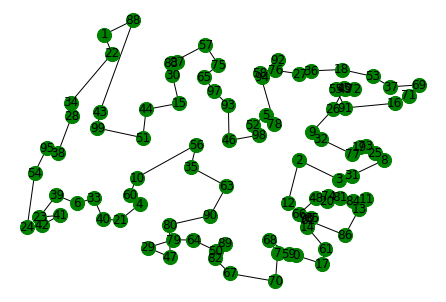

In [18]:
run_10_times(nb_iteration = 300,nb_villes = 100 , filename = "distances_entre_villes_100.txt",duree_tabou=100)